In [25]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ficc.utils.auxiliary_variables import SPECIAL_CONDITIONS
from ficc.utils.adding_flags import get_most_recent_index_and_others

import sys
sys.path.insert(0,'../../../../ficc/ml_models/sequence_predictors/')

from yield_spread_model_mitas.data_prep import get_datestring_from_filename, \
                                               replace_rating_with_standalone_rating, \
                                               remove_rows_with_feature_value

from rating_model_mitas.data_prep import read_processed_file_pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Silence the following warning: `SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.`

In [2]:
pd.options.mode.chained_assignment = None

# Load the dataframe

In [3]:
%%time
processed_file_pickle = '../data/processed_data_2022-06-13-19-19.pkl'
processed_file_pickle_datestring = get_datestring_from_filename(processed_file_pickle)
trade_data = read_processed_file_pickle(processed_file_pickle)
# ensure that all column names are unique
assert len(trade_data.columns) == len(set(trade_data)), 'Not all column names are unique'

START: Reading from processed file at ../data/processed_data_2022-06-13-19-19.pkl
END: Reading from processed file at ../data/processed_data_2022-06-13-19-19.pkl
CPU times: user 2.58 s, sys: 1.58 s, total: 4.16 s
Wall time: 5.47 s


## Exclusions

In [4]:
trade_data = trade_data[(trade_data.days_to_call == 0) | (trade_data.days_to_call > np.log10(400))]
trade_data = trade_data[(trade_data.days_to_refund == 0) | (trade_data.days_to_refund > np.log10(400))]
trade_data = trade_data[trade_data.days_to_maturity < np.log10(30000)]
trade_data = trade_data[trade_data.sinking == False]
trade_data = trade_data[trade_data.incorporated_state_code != 'VI']
trade_data = trade_data[trade_data.incorporated_state_code != 'GU']
trade_data = trade_data[(trade_data.coupon_type == 8)]
trade_data = trade_data[trade_data.is_called == False]

In [5]:
# restructured bonds and high chance of default bonds are removed
trade_data = remove_rows_with_feature_value(trade_data, 'purpose_sub_class', [6, 20, 21, 22, 44, 57, 90, 106])
# pre-refunded bonds and partially refunded bonds are removed
trade_data = remove_rows_with_feature_value(trade_data, 'called_redemption_type', [18, 19])
trade_data = replace_rating_with_standalone_rating(trade_data)

(df["purpose_sub_class"] != 6) & (df["purpose_sub_class"] != 20) & (df["purpose_sub_class"] != 21) & (df["purpose_sub_class"] != 22) & (df["purpose_sub_class"] != 44) & (df["purpose_sub_class"] != 57) & (df["purpose_sub_class"] != 90) & (df["purpose_sub_class"] != 106)
39566 rows had purpose_sub_class in [6, 20, 21, 22, 44, 57, 90, 106] and were removed
(df["called_redemption_type"] != 18) & (df["called_redemption_type"] != 19)
11590 rows had called_redemption_type in [18, 19] and were removed


In [6]:
trade_data_original = trade_data.copy()

In [7]:
print(f'Number of trades: {len(trade_data)}')

Number of trades: 2401047


In [8]:
FEATURES_OF_INTEREST = ['cusip', 'quantity', 'dollar_price', 'trade_datetime', 'trade_type']
IDENTIFIERS = ['cusip', 'rtrs_control_number']
ALL_IMPORTANT_FEATURES = list(set().union(FEATURES_OF_INTEREST + IDENTIFIERS + SPECIAL_CONDITIONS))

In [9]:
trade_data_select_features = trade_data[ALL_IMPORTANT_FEATURES]
trade_data_select_features['brokers_broker'] = trade_data_select_features['brokers_broker'].astype('string').fillna('none')    # replace the NaN value with 'none' so that we can use groupby (groupby doesn't work for NaN even with the dropna flag)

# Isolate suspicious trades
*Goal*: find trades with the same CUSIP, same quantity, and same price, and all occurring within a short period of time.
1. Group by CUSIP, quantity, price, and date
2. Only focus on groups with two or more trades

Results of analyzing isolated trades are here: https://docs.google.com/document/d/1CNSqIn4FlKKcgaSiwhFjznIVlhNPOA15nV8Nt19z2Ng/edit?usp=sharing

In [10]:
%%time
# running time is basically the same as creating a new column with the trade_datetime as just a date (removing the time) and matching on that
groups = trade_data_select_features.groupby([pd.Grouper(key='trade_datetime', freq='1D'), 'quantity', 'dollar_price', 'cusip'])    # moving the grouper to the beginning to sort based on that
groups = {group_key: group_df for group_key, group_df in groups if len(group_df) > 1}    # removes groups with only 1 item since this is not really a group
print(f'Number of groups: {len(groups)}')

Number of groups: 333637
CPU times: user 57.1 s, sys: 692 ms, total: 57.8 s
Wall time: 57.7 s


In [11]:
num_keys = 10

In [12]:
def print_first_n_keys(keys, key_to_df_dict, n):
    for key in keys[:n]:
        print(f'{key}: {len(key_to_df_dict[key])} trades')

## Not only dealer-dealer

In [13]:
%%time
groups_not_only_dd = {group_key: group_df for group_key, group_df in groups.items() if set(group_df['trade_type']) != {'D'}}    # remove all groups with just dealer-dealer trades
print(f'Number of groups without only dealer-dealer trades: {len(groups_not_only_dd)}')

Number of groups without only dealer-dealer trades: 263063
CPU times: user 8.15 s, sys: 230 ms, total: 8.38 s
Wall time: 8.31 s


In [14]:
keys_not_only_dd_descending_timestamp = sorted(groups_not_only_dd.keys(), reverse=True)    # sorting with reverse=True to see the most recent trades with largest quantity and dollar price
keys_not_only_dd_descending_quantity = sorted(groups_not_only_dd.keys(), key=lambda features: (features[1], features[0], features[2], features[3]), reverse=True)

In [15]:
print_first_n_keys(keys_not_only_dd_descending_timestamp, groups_not_only_dd, num_keys)

(Timestamp('2022-06-10 00:00:00', freq='D'), 6.698969841003418, 129.551, '13063A5E0'): 2 trades
(Timestamp('2022-06-10 00:00:00', freq='D'), 6.698969841003418, 109.244, '74265LS66'): 2 trades
(Timestamp('2022-06-10 00:00:00', freq='D'), 6.698969841003418, 104.364, '59333PL30'): 2 trades
(Timestamp('2022-06-10 00:00:00', freq='D'), 6.653212547302246, 97.462, '977100GH3'): 2 trades
(Timestamp('2022-06-10 00:00:00', freq='D'), 6.3664231300354, 110.854, '88213AFB6'): 2 trades
(Timestamp('2022-06-10 00:00:00', freq='D'), 6.360782623291016, 115.282, '343137KL8'): 2 trades
(Timestamp('2022-06-10 00:00:00', freq='D'), 6.301030158996582, 101.415, '13032UFL7'): 2 trades
(Timestamp('2022-06-10 00:00:00', freq='D'), 6.301030158996582, 81.579, '735000TV3'): 2 trades
(Timestamp('2022-06-10 00:00:00', freq='D'), 6.296665191650391, 108.993, '928172Q65'): 2 trades
(Timestamp('2022-06-10 00:00:00', freq='D'), 6.293362617492676, 108.487, '554265CM8'): 2 trades


In [16]:
print_first_n_keys(keys_not_only_dd_descending_quantity, groups_not_only_dd, num_keys)

(Timestamp('2021-11-19 00:00:00', freq='D'), 7.7693772315979, 100.224, '13063DL22'): 2 trades
(Timestamp('2022-02-01 00:00:00', freq='D'), 7.698969841003418, 100.859, '57582RW51'): 2 trades
(Timestamp('2022-03-04 00:00:00', freq='D'), 7.548389434814453, 118.592, '403755Y54'): 2 trades
(Timestamp('2022-04-20 00:00:00', freq='D'), 7.5427632331848145, 100.493, '64990FYP3'): 2 trades
(Timestamp('2022-04-20 00:00:00', freq='D'), 7.5427632331848145, 100.393, '64990FYP3'): 2 trades
(Timestamp('2021-12-01 00:00:00', freq='D'), 7.525368690490723, 114.719, '57584XYC9'): 2 trades
(Timestamp('2022-04-05 00:00:00', freq='D'), 7.506098747253418, 119.345, '13063DE53'): 2 trades
(Timestamp('2021-10-04 00:00:00', freq='D'), 7.462996482849121, 128.577, '93974ESA5'): 2 trades
(Timestamp('2021-10-04 00:00:00', freq='D'), 7.462996482849121, 128.477, '93974ESA5'): 2 trades
(Timestamp('2022-02-08 00:00:00', freq='D'), 7.447157859802246, 124.364, '452252PW3'): 2 trades


## Only dealer-dealer
May be able to combine a sequence of inter-dealer trades with the same price as a single one

In [17]:
%%time
groups_only_dd = {group_key: group_df for group_key, group_df in groups.items() if set(group_df['trade_type']) == {'D'}}    # keeps groups with just dealer-dealer trades
print(f'Number of groups with only dealer-dealer trades: {len(groups_only_dd)}')

Number of groups with only dealer-dealer trades: 70574
CPU times: user 3.42 s, sys: 41.9 ms, total: 3.46 s
Wall time: 3.45 s


[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 19, 20, 21, 23, 28, 42]
[64431, 4588, 1100, 149, 195, 28, 33, 14, 16, 4, 6, 1, 2, 1, 1, 1, 1, 1, 1, 1]


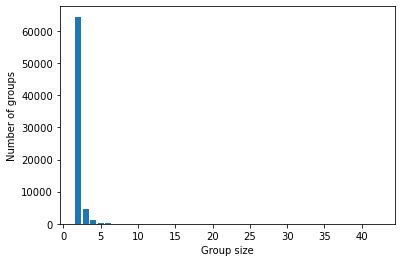

In [29]:
size_to_count = dict()
for group_df in groups_only_dd.values():
    size = len(group_df)
    if size not in size_to_count: size_to_count[size] = 0
    size_to_count[size] += 1
sorted_keys = sorted(size_to_count.keys())
counts_corresponding_to_sorted_keys = [size_to_count[key] for key in sorted_keys]
print(sorted_keys)
print(counts_corresponding_to_sorted_keys)
plt.bar(sorted_keys, counts_corresponding_to_sorted_keys)
plt.xlabel('Group size')
plt.ylabel('Number of groups')
plt.show()

In [31]:
for group_key, group_df in groups_only_dd.items():
    if len(group_df) >= 20: print(group_key)

(Timestamp('2022-03-22 00:00:00', freq='D'), 4.397940158843994, 103.223, '73358WSH8')
(Timestamp('2022-04-21 00:00:00', freq='D'), 4.397940158843994, 98.75, '89602HBR7')
(Timestamp('2022-05-16 00:00:00', freq='D'), 4.397940158843994, 97.832, '497766EB7')
(Timestamp('2022-05-17 00:00:00', freq='D'), 4.397940158843994, 97.773, '914353L39')
(Timestamp('2022-05-17 00:00:00', freq='D'), 4.397940158843994, 98.023, '914353L39')


In [18]:
keys_only_dd_descending_timestamp = sorted(groups_only_dd.keys(), reverse=True)    # sorting with reverse=True to see the most recent trades with largest quantity and dollar price
keys_only_dd_descending_quantity = sorted(groups_only_dd.keys(), key=lambda features: (features[1], features[0], features[2], features[3]), reverse=True)

In [19]:
print_first_n_keys(keys_only_dd_descending_timestamp, groups_only_dd, num_keys)

(Timestamp('2022-06-10 00:00:00', freq='D'), 6.698969841003418, 104.114, '59333PL30'): 2 trades
(Timestamp('2022-06-10 00:00:00', freq='D'), 5.903090000152588, 110.44, '546399JR8'): 2 trades
(Timestamp('2022-06-10 00:00:00', freq='D'), 5.698969841003418, 104.345, '123776XH4'): 3 trades
(Timestamp('2022-06-10 00:00:00', freq='D'), 5.698969841003418, 102.493, '420218TW9'): 2 trades
(Timestamp('2022-06-10 00:00:00', freq='D'), 5.698969841003418, 99.462, '574204R96'): 2 trades
(Timestamp('2022-06-10 00:00:00', freq='D'), 5.51188325881958, 110.901, '353204AV2'): 2 trades
(Timestamp('2022-06-10 00:00:00', freq='D'), 5.505149841308594, 98.625, '274137S33'): 2 trades
(Timestamp('2022-06-10 00:00:00', freq='D'), 5.477121353149414, 100.0, '457110NH3'): 2 trades
(Timestamp('2022-06-10 00:00:00', freq='D'), 5.462398052215576, 111.648, '293443C47'): 2 trades
(Timestamp('2022-06-10 00:00:00', freq='D'), 5.447157859802246, 112.64, '744873GE4'): 2 trades


In [20]:
print_first_n_keys(keys_only_dd_descending_quantity, groups_only_dd, num_keys)

(Timestamp('2021-11-05 00:00:00', freq='D'), 7.314183235168457, 132.506, '91514AJW6'): 2 trades
(Timestamp('2022-01-12 00:00:00', freq='D'), 7.301030158996582, 117.812, '64972GZP2'): 2 trades
(Timestamp('2021-08-02 00:00:00', freq='D'), 7.22023868560791, 133.912, '57604TJX5'): 2 trades
(Timestamp('2021-08-02 00:00:00', freq='D'), 7.206151008605957, 138.552, '373385HR7'): 2 trades
(Timestamp('2021-08-02 00:00:00', freq='D'), 7.206151008605957, 138.29, '373385HR7'): 2 trades
(Timestamp('2021-11-05 00:00:00', freq='D'), 7.201533794403076, 124.091, '373385HT3'): 2 trades
(Timestamp('2021-12-09 00:00:00', freq='D'), 7.176091194152832, 119.484, '57584XYA3'): 2 trades
(Timestamp('2022-02-18 00:00:00', freq='D'), 7.13033390045166, 113.569, '64990FZS6'): 2 trades
(Timestamp('2022-04-20 00:00:00', freq='D'), 7.1301727294921875, 102.343, '64972GWU4'): 2 trades
(Timestamp('2022-03-23 00:00:00', freq='D'), 7.1301727294921875, 106.484, '64972GWU4'): 2 trades


In [21]:
# create a dictionary that maps a length to all the keys that correspond to dataframes of this length
group_keys_only_dd_by_len = defaultdict(set)
for group_key, group_df in groups_only_dd.items():
    group_keys_only_dd_by_len[len(group_df)].add(group_key)

In [22]:
keys_only_dd_larger_than2 = set().union(*[group_keys_only_dd_by_len[key] for key in group_keys_only_dd_by_len if key > 2])
keys_only_dd_larger_than2_descending_timestamp = sorted(keys_only_dd_larger_than2, reverse=True)    # sorting with reverse=True to see the most recent trades with largest quantity and dollar price
keys_only_dd_larger_than2_descending_quantity = sorted(keys_only_dd_larger_than2, key=lambda features: (features[1], features[0], features[2], features[3]), reverse=True)

In [23]:
print_first_n_keys(keys_only_dd_larger_than2_descending_timestamp, groups_only_dd, num_keys)

(Timestamp('2022-06-10 00:00:00', freq='D'), 5.698969841003418, 104.345, '123776XH4'): 3 trades
(Timestamp('2022-06-10 00:00:00', freq='D'), 5.397940158843994, 110.452, '546399JR8'): 4 trades
(Timestamp('2022-06-10 00:00:00', freq='D'), 5.397940158843994, 97.877, '64990FL28'): 3 trades
(Timestamp('2022-06-10 00:00:00', freq='D'), 5.301030158996582, 89.32, '92778VLC0'): 3 trades
(Timestamp('2022-06-10 00:00:00', freq='D'), 5.0, 113.198, '081617SC7'): 3 trades
(Timestamp('2022-06-10 00:00:00', freq='D'), 5.0, 110.012, '041806QC7'): 3 trades
(Timestamp('2022-06-10 00:00:00', freq='D'), 5.0, 107.301, '986370LQ5'): 3 trades
(Timestamp('2022-06-10 00:00:00', freq='D'), 5.0, 99.064, '64990FZT4'): 3 trades
(Timestamp('2022-06-10 00:00:00', freq='D'), 5.0, 98.5, '645790QC3'): 3 trades
(Timestamp('2022-06-10 00:00:00', freq='D'), 4.87506103515625, 101.996, '828641XJ4'): 3 trades


In [24]:
print_first_n_keys(keys_only_dd_larger_than2_descending_quantity, groups_only_dd, num_keys)

(Timestamp('2021-11-04 00:00:00', freq='D'), 7.0, 119.48, '64985TCK5'): 4 trades
(Timestamp('2021-10-06 00:00:00', freq='D'), 6.698969841003418, 123.062, '373385HT3'): 3 trades
(Timestamp('2022-05-02 00:00:00', freq='D'), 6.397940158843994, 98.592, '677524DW7'): 3 trades
(Timestamp('2022-02-14 00:00:00', freq='D'), 6.397940158843994, 104.209, '13063B3W0'): 3 trades
(Timestamp('2022-04-06 00:00:00', freq='D'), 6.3424224853515625, 104.578, '13063CEN6'): 3 trades
(Timestamp('2022-03-10 00:00:00', freq='D'), 6.339451313018799, 122.672, '93974ENS1'): 3 trades
(Timestamp('2022-03-11 00:00:00', freq='D'), 6.301030158996582, 107.816, '544646R53'): 3 trades
(Timestamp('2022-04-29 00:00:00', freq='D'), 6.20412015914917, 106.728, '64985TBW0'): 3 trades
(Timestamp('2021-09-29 00:00:00', freq='D'), 6.18326997756958, 120.69, '64990AEZ4'): 3 trades
(Timestamp('2022-03-11 00:00:00', freq='D'), 6.176091194152832, 108.443, '13063CMX5'): 3 trades
